# Predicting Heart Disease with Classifier Models

## Data obtained from UCI Machine Learning Repository

### Additional Info
"This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them.  In particular, the Cleveland database is the only one that has been used by ML researchers to date.  The "goal" field refers to the presence of heart disease in the patient.  It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0)."

### Key Skills Covered
- Data cleaning, data engineering, machine learning

#### Citation
Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

*https://archive.ics.uci.edu/dataset/45/heart+disease*

**@author:** 2pitesh

**Columns**

**id**: patient id number, **ccf**: ssn (replaced with dummy val), **age**: age in years, **sex**: 1=male, 0=female, **painloc**: chest pain location (1=substernal, 0=otherwise), **painexer**: (1=provoked by exertion, 0=otherwise), **relrest**: 1=relieved after rest, 0=otherwise, **pncaden**: sum of painloc, painexer, and relrest, **cp**: chest pain type (value 1: typical angina, value 2: atypical angina, value 3: non-anginal pain, value 4: asymptomatic), **trestbps**: resting blood pressure (in mm Hg), **htn**, **chol**: serum cholestoral mg/dl, **smoke**: 1=yes, 0=no, **cigs**: cigarettes per day, **years**: number of years as a smoker, **fbs**: fasting blood sugar > 120 mg/dl (1=true, 0=false), **dm**: 1=history of diabetes, 0=no such history, **famhist**: family history of coronary artery disease (1=yes, 0=no), **restecg**: resting electrocardiographic results ()

In [1]:
# install the ucimlrepo package
%pip install ucimlrepo
%pip install shap

Note: you may need to restart the kernel to use updated packages.  Downloading ucimlrepo-0.0.3-py3-none-any.whl.metadata (5.2 kB)



In [12]:
# import the dataset
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
# fetch dataset and additional information
heart_disease = fetch_ucirepo(id=45)
print(type(heart_disease))
print(heart_disease.metadata)
print(heart_disease.variables)

<class 'ucimlrepo.dotdict.dotdict'>
{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfi

In [10]:
# you can import the data already as a dataframe
x_features = heart_disease.data.features
y_target = heart_disease.data.targets
#df = pd.DataFrame(features, target)
print(x_features.head())
print(y_target.head())

   age  sex  cp  trestbps  chol  fbs  ...  thalach  exang  oldpeak  slope   ca  thal
0   63    1   1       145   233    1  ...      150      0      2.3      3  0.0   6.0
1   67    1   4       160   286    0  ...      108      1      1.5      2  3.0   3.0
2   67    1   4       120   229    0  ...      129      1      2.6      2  2.0   7.0
3   37    1   3       130   250    0  ...      187      0      3.5      3  0.0   3.0
4   41    0   2       130   204    0  ...      172      0      1.4      1  0.0   3.0

[5 rows x 13 columns]
   num
0    0
1    2
2    1
3    0
4    0


## Data Cleaning

### **Preprocess the data to see what you're working with**

**What are the unique values in each column?**

In [20]:
# determine how many unique values are present for the different features
feature_cols = pd.Series(x_features.columns)
# iterate through the series and print out the col name and num of unique val
def getUniqueVals(df, cols):
    df_unique = pd.DataFrame(columns=['feature', '#_val', 'unique_vals'])
    for i in cols:
        # print("'{}' feature has {} unique values \n Which are {}.".format(str(i), df[str(i)].nunique(), df[str(i)].unique()))
        row = [str(i), int(df[str(i)].nunique()), str(df[str(i)].unique())]
        df_unique.loc[len(df_unique)] = row
    return df_unique

uniq_vals = getUniqueVals(x_features, feature_cols)
uniq_vals.head()

,feature,#_val,unique_vals
0,age,41,[63 67 37 41 56 62 57 53 44 52 48 54 49 64 58 ...
1,sex,2,[1 0]
2,cp,4,[1 4 3 2]
3,trestbps,50,[145 160 120 130 140 172 150 110 132 117 135 1...
4,chol,152,[233 286 229 250 204 236 268 354 254 203 192 2...


The most important feature that I wanted to confirm the unique values for was for sex, since this dataset should only have 2. This was to confirm that the information was inputed correctly.

**Compare the number of male and females in the dataset**

This is important overall since sex may play a role in predicting heart disease.

Where 1 = Male 
      0 = Female


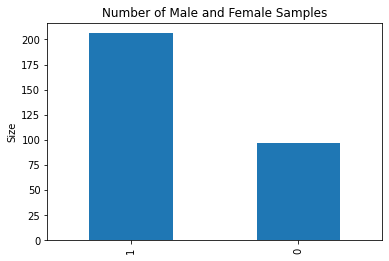

In [30]:
# where 1 = male, 0 = female
x_features['sex'].value_counts().plot(kind='bar', title='Number of Male and Female Samples', ylabel='Size')
print("Where 1 = Male \n      0 = Female")

### What are the age ranges?

Add age rangea a new columns in the feature dataset

In [36]:
age_ranges = ["[{0} - {1})".format(age, age + 10) for age in range(10, 110, 10)] # make sure range is wide enough to get young and old people
age_ranges

['[10 - 20)',
 '[20 - 30)',
 '[30 - 40)',
 '[40 - 50)',
 '[50 - 60)',
 '[60 - 70)',
 '[70 - 80)',
 '[80 - 90)',
 '[90 - 100)',
 '[100 - 110)']

In [37]:
x_features['age_range'] = pd.cut(x=x_features['age'], bins=10, labels=age_ranges)
x_features.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,age_range
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,[80 - 90)
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,[80 - 90)
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,[80 - 90)
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,[20 - 30)
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,[30 - 40)


In [35]:
# Get an idea for the number of people in each age range
x_features['age_range'].value_counts()

[60 - 70)     85
[70 - 80)     58
[50 - 60)     52
[40 - 50)     47
[80 - 90)     30
[30 - 40)     21
[20 - 30)      7
[90 - 100)     3
Name: age_range, dtype: int64

It looks like the patients in this dataset age range from 60-100. There are no patients younger than 60 in this dataset.

### Get the correlation values for the freatures and display

In [38]:
corr_val = x_features.corr()
corr_val

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
age,1.000000,-0.097542,0.104139,0.284946,0.208950,0.118530,0.148868,-0.393806,0.091661,0.203805,0.161770,0.362605,0.127389
sex,-0.097542,1.000000,0.010084,-0.064456,-0.199915,0.047862,0.021647,-0.048663,0.146201,0.102173,0.037533,0.093185,0.380936
cp,0.104139,0.010084,1.000000,-0.036077,0.072319,-0.039975,0.067505,-0.334422,0.384060,0.202277,0.152050,0.233214,0.265246
trestbps,0.284946,-0.064456,-0.036077,1.000000,0.130120,0.175340,0.146560,-0.045351,0.064762,0.189171,0.117382,0.098773,0.133554
chol,0.208950,-0.199915,0.072319,0.130120,1.000000,0.009841,0.171043,-0.003432,0.061310,0.046564,-0.004062,0.119000,0.014214
fbs,0.118530,0.047862,-0.039975,0.175340,0.009841,1.000000,0.069564,-0.007854,0.025665,0.005747,0.059894,0.145478,0.071358
restecg,0.148868,0.021647,0.067505,0.146560,0.171043,0.069564,1.000000,-0.083389,0.084867,0.114133,0.133946,0.128343,0.024531
thalach,-0.393806,-0.048663,-0.334422,-0.045351,-0.003432,-0.007854,-0.083389,1.000000,-0.378103,-0.343085,-0.385601,-0.264246,-0.279631
exang,0.091661,0.146201,0.384060,0.064762,0.061310,0.025665,0.084867,-0.378103,1.000000,0.288223,0.257748,0.145570,0.329680
oldpeak,0.203805,0.102173,0.202277,0.189171,0.046564,0.005747,0.114133,-0.343085,0.288223,1.000000,0.577537,0.295832,0.341004


<AxesSubplot:>

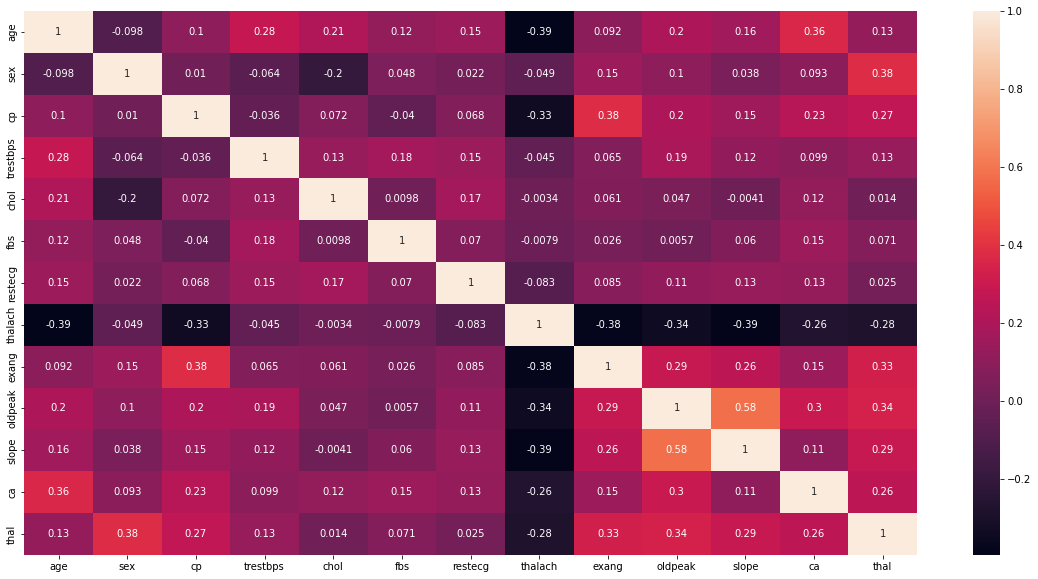

In [43]:
plt.figure(figsize=(20,10))
sns.heatmap(corr_val, annot=True)